In [376]:
import numpy as np
from scipy import linalg as la

# Problems 1-4

In [377]:
def interiorPoint(A, b, c, niter=20, tol=1e-16):
    
    n = len(c)  # length of x, c, μ
    m = len(b)  # length of b, λ
    
    def F(x, λ, μ):
        M = μ * np.identity(n)
        top = np.array(A.T @ λ + μ - c)
        middle = np.array(A @ x - b)
        bottom = np.array(M @ x)
        return np.concatenate((top, middle, bottom))
    
    σ = 1 / 10
    
    DF_top = np.hstack((np.zeros((n, n)), A.T, np.identity(n)))
    DF_middle = np.hstack((A, np.zeros((m, m + n))))
    
    def DF(M, X):
        DF_bottom = np.hstack((M, np.zeros((n, m)), X))
        return np.vstack((DF_top, DF_middle, DF_bottom))
    
    it = 0
    dist = 100
    x, λ, μ = starting_point(A, b, c)
    while dist > tol and it < niter:
        ν = (x @ μ) / n
        e = np.ones(n)
        M = μ * np.identity(n)
        X = x * np.identity(n)
        
        RHS = -F(x, λ, μ) + np.concatenate((np.zeros(n + m), σ * ν * e))
        lu, piv = la.lu_factor(DF(M, X))
        result = la.lu_solve((lu, piv), RHS)
        Δx = result[:n]
        Δλ = result[n:m+n]
        Δμ = result[m+n:]

        α_max = np.min([np.min(-μ[Δμ < 0] / Δμ[Δμ < 0]), 1.0])
        δ_max = np.min([np.min(-x[Δx < 0] / Δx[Δx < 0]), 1.0])

        α = np.min([1, 0.95 * α_max])
        δ = np.min([1, 0.95 * δ_max])
        x_next = x + δ * Δx
        λ = λ + α * Δλ
        μ = μ + α * Δμ
        
        dist = la.norm(x_next - x)
        x = x_next
        it += 1
    return x, c @ x

In [378]:
def starting_point(A, b, c):
    """Calculate an initial guess to the solution of the linear program
    min c\trp  x, Ax = b, x>=0.
    Reference: Nocedal and Wright, p. 410.
    """
    # Calculate x, λ, μ of minimal norm satisfying both
    # the primal and dual constraints.
    B = la.inv(A @ A.T)
    x = A.T @ B @ b
    λ = B @ A @ c
    μ = c - (A.T @ λ)
    # Perturb x and s so they are nonnegative.
    dx = max((-3. / 2)* x.min(), 0)
    dμ = max((-3. / 2) * μ.min(), 0)
    x += dx * np.ones_like(x)
    μ += dμ * np.ones_like(μ)
    # Perturb x and μ so they are not too small and not too dissimilar.
    dx = .5 * (x * μ).sum() / μ.sum()
    dμ = .5 * (x * μ).sum() / x.sum()
    x += dx * np.ones_like(x)
    μ += dμ * np.ones_like(μ)
    return x, λ, μ

In [379]:
def randomLP(m, n):
    """Generate a linear program min c\trp  x s.t. Ax = b, x>=0.
    First generate m feasible constraints, then add
    slack variables to convert it into the above form.
    Inputs:
        m (int >= n): number of desired constraints.
        n (int): dimension of space in which to optimize.
    Outputs:
        A ((m,n+m) ndarray): Constraint matrix.
        b ((m,) ndarray): Constraint vector.
        c ((n+m,), ndarray): Objective function with m trailing 0s.
        x ((n,) ndarray): The first 'n' terms of the solution to the LP.
    """
    A = np.random.random((m,n))*20 - 10
    A[A[:,-1]<0] *= -1
    x = np.random.random(n)*10
    b = np.zeros(m)
    b[:n] = A[:n,:] @ x
    b[n:] = A[n:,:] @ x + np.random.random(m-n)*10
    c = np.zeros(n+m)
    c[:n] = A[:n,:].sum(axis=0)/n
    A = np.hstack((A, np.eye(m)))
    return A, b, -c, x

In [380]:
m, n = 7, 5
A, b, c, x = randomLP(m, n)
point, value = interiorPoint(A, b, c)

In [381]:
print("x:", x, "\nSolution:", point[:n])

x: [7.58567589 6.52814782 1.58820046 0.59231416 4.42480999] 
Solution: [7.58567589 6.52814782 1.58820046 0.59231416 4.42480999]


In [382]:
np.allclose(x, point[:n])

True

In [383]:
print("Value:", c[:n] @ x, "\nSolution value:", value)

Value: 49.69423848140784 
Solution value: 49.69423848140782


In [384]:
np.allclose(c[:n] @ x, value)

True

# Problem 5

In [385]:
simdata = np.loadtxt("simdata.txt")

In [386]:
simdata

array([[39.22166889,  0.33994899],
       [36.77516506,  0.91801125],
       [21.7168137 ,  0.94267081],
       [33.94802972,  1.19618335],
       [23.10127361,  1.81574744],
       [30.39111645,  2.34383565],
       [30.8560133 ,  2.37090545],
       [29.98288939,  2.45355553],
       [30.15483543,  2.61394645],
       [24.04689978,  3.71804098],
       [23.67297828,  3.94392332],
       [24.08635478,  4.08453521],
       [19.2267982 ,  5.3492233 ],
       [18.46270771,  5.464175  ],
       [15.81407537,  5.57897281],
       [17.46656624,  5.58047072],
       [19.1146746 ,  5.62377167],
       [14.36968471,  6.52048436],
       [ 9.95033449,  6.96880179],
       [ 9.52403274,  7.86391972],
       [ 7.29231171,  8.22808448],
       [ 6.64322922,  8.46952999],
       [ 3.66183831,  8.98590661],
       [12.91276383,  9.06404501],
       [15.64864908,  9.63632793]])

In [387]:
m = simdata.shape[0]
n = simdata.shape[1] - 1

In [388]:
c = np.zeros(3*m + 2*(n + 1))
c[:m] = 1
y = np.empty(2*m)
y[::2] = -simdata[:, 0]
y[1::2] = simdata[:, 0]
x = simdata[:, 1:]

In [389]:
A = np.ones((2*m, 3*m + 2*(n + 1)))
A[::2, :m] = np.eye(m)
A[1::2, :m] = np.eye(m)
A[::2, m:m+n] = -x
A[1::2, m:m+n] = x
A[::2, m+n:m+2*n] = x
A[1::2, m+n:m+2*n] = -x
A[::2, m+2*n] = -1
A[1::2, m+2*n+1] = -1
A[:, m+2*n+2:] = -np.eye(2*m, 2*m)

In [390]:
sol = interiorPoint(A, y, c, niter=10)[0]

In [391]:
β = sol[m:m+n] - sol[m+n:m+2*n]
b = sol[m+2*n] - sol[m+2*n+1]

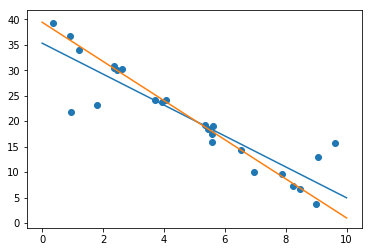

In [392]:
from scipy.stats import linregress
from matplotlib import pyplot as plt
slope, intercept = linregress(simdata[:,1], simdata[:,0])[:2]
domain = np.linspace(0,10,200)
plt.plot(domain, domain*slope + intercept)
plt.plot(domain, domain*β + b)
plt.scatter(simdata[:, 1], simdata[:, 0])
plt.show()